In [1]:
# import libraries
import os
from tqdm import tqdm
import cv2
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# model tools
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# model
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import BatchNormalization
from keras.layers import SpatialDropout2D
from keras.layers import Flatten
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import GaussianNoise
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator


# code copied from 
from keras.utils.data_utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator


# to load training images
import cv2

Using TensorFlow backend.


[Code Source](https://medium.com/analytics-vidhya/how-to-apply-data-augmentation-to-deal-with-unbalanced-datasets-in-20-lines-of-code-ada8521320c9)

# Intro

The goal pf this project is to build a stell defect detector. This [kaggle](https://www.kaggle.com/c/severstal-steel-defect-detection/notebooks?sortBy=hotness&group=everyone&pageSize=20&competitionId=14241&language=Python&outputType=Visualization) dataset provides images with four types of defects. To build an algorithm capable of identifying and count the type of defects in an image is a two steps process. The firt step is to classify if the image has a defect or not. If the image has a defect the second step is to identify the type fo defects and count them. In this notebook we will build a binary image classifier to determine if steel has a defect.

According to the EDA done by this [person](https://www.kaggle.com/go1dfish/clear-mask-visualization-and-simple-eda) the train csv file only contains the images that have defects and each class label represents the type of defect. In other words, one single image can have more than one class label. To solve this problem the proper approach would be to first detect if there is a defect. To separat the images that have defects and those that do not I will create two directories one for each.


# Feature Engineering

In [2]:
base_dir = '/Users/carlostavarez/Desktop/severstal-steel-defect-detection'

In [3]:
images_tr_dir = base_dir + '/train_images'

In [4]:
df = pd.read_csv(base_dir + '/train.csv')

In [5]:
df.shape

(7095, 3)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7095 entries, 0 to 7094
Data columns (total 3 columns):
ImageId          7095 non-null object
ClassId          7095 non-null int64
EncodedPixels    7095 non-null object
dtypes: int64(1), object(2)
memory usage: 166.4+ KB


In [7]:
df.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [8]:
df = df.pivot(index='ImageId', values='ClassId', columns='ClassId').fillna(0)

In [9]:
numb_dict = {
    0:0, 1:1, 2:1, 3:1, 4:1
}

In [10]:
df.head()

ClassId,1,2,3,4
ImageId,,,,
0002cc93b.jpg,1.0,0.0,0.0,0.0
0007a71bf.jpg,0.0,0.0,3.0,0.0
000a4bcdd.jpg,1.0,0.0,0.0,0.0
000f6bf48.jpg,0.0,0.0,0.0,4.0
0014fce06.jpg,0.0,0.0,3.0,0.0


In [11]:
df[1] = df[1].map(numb_dict)
df[2] = df[2].map(numb_dict)
df[3] = df[3].map(numb_dict)
df[4] = df[4].map(numb_dict)

In [12]:
df.head()

ClassId,1,2,3,4
ImageId,,,,
0002cc93b.jpg,1,0,0,0
0007a71bf.jpg,0,0,1,0
000a4bcdd.jpg,1,0,0,0
000f6bf48.jpg,0,0,0,1
0014fce06.jpg,0,0,1,0


In [13]:
df[5] = df.sum(axis=1)

In [14]:
df.head()

ClassId,1,2,3,4,5
ImageId,,,,,
0002cc93b.jpg,1,0,0,0,1
0007a71bf.jpg,0,0,1,0,1
000a4bcdd.jpg,1,0,0,0,1
000f6bf48.jpg,0,0,0,1,1
0014fce06.jpg,0,0,1,0,1


In [15]:
df_defects2 = df[df[5] > 1]
df_defects = df[df[5] == 1]

In [16]:
df_defects.describe()

ClassId,1,2,3,4,5
count,6239.000000,6239.000000,6239.000000,6239.000000,6239.0
mean,0.123257,0.031255,0.762782,0.082706,1.0
std,0.328758,0.174020,0.425411,0.275459,0.0
min,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.000000,0.000000,1.000000,0.000000,1.0
50%,0.000000,0.000000,1.000000,0.000000,1.0
75%,0.000000,0.000000,1.000000,0.000000,1.0
max,1.000000,1.000000,1.000000,1.000000,1.0


In [17]:
df_defects = df_defects.drop(5, axis=1)

In [18]:
df_defects.sum()

ClassId
1     769
2     195
3    4759
4     516
dtype: int64

In [19]:
df_defects.shape, df_defects2.shape

((6239, 4), (427, 5))

In [20]:
df_defects[2] = df_defects[2].map({0:0, 1:2})
df_defects[3] = df_defects[3].map({0:0, 1:3})
df_defects[4] = df_defects[4].map({0:0, 1:4})

In [21]:
df_defects['label'] = df_defects.sum(axis=1)

In [22]:
df_defects.head()

ClassId,1,2,3,4,label
ImageId,,,,,
0002cc93b.jpg,1,0,0,0,1
0007a71bf.jpg,0,0,3,0,3
000a4bcdd.jpg,1,0,0,0,1
000f6bf48.jpg,0,0,0,4,4
0014fce06.jpg,0,0,3,0,3


In [23]:
df_defects = df_defects.reset_index()

In [24]:
df_defects.head()

ClassId,ImageId,1,2,3,4,label
0,0002cc93b.jpg,1,0,0,0,1
1,0007a71bf.jpg,0,0,3,0,3
2,000a4bcdd.jpg,1,0,0,0,1
3,000f6bf48.jpg,0,0,0,4,4
4,0014fce06.jpg,0,0,3,0,3


In [25]:
df_f = df_defects.loc[:, ['ImageId', 'label']]

In [26]:
df_f.loc[:, ['ImageId', 'label']]

ClassId,ImageId,label
0,0002cc93b.jpg,1
1,0007a71bf.jpg,3
2,000a4bcdd.jpg,1
3,000f6bf48.jpg,4
4,0014fce06.jpg,3
...,...,...
6234,ffcf72ecf.jpg,3
6235,fff02e9c5.jpg,3
6236,fffe98443.jpg,3
6237,ffff4eaa8.jpg,3


In [27]:
df = df.reset_index()

In [28]:
imgs_defect_set = set(df['ImageId'].unique())

In [29]:
ims_dir_set = set(os.listdir(images_tr_dir))

In [30]:
imgs_noDefect_set = ims_dir_set.difference(imgs_defect_set)

In [31]:
no_defects_df = pd.DataFrame(imgs_noDefect_set, columns=['ImageId'])

In [32]:
# no_defects_df.head()

In [33]:
no_defects_df['label'] = 0

In [34]:
no_defects_df.head()

,ImageId,label
0,a705b49f9.jpg,0
1,ebe4ba4f4.jpg,0
2,d2f6c8fa2.jpg,0
3,1f86fdb5b.jpg,0
4,98914c1c2.jpg,0


In [35]:
imgs_df = pd.concat([no_defects_df, df_f], ignore_index=True)

In [36]:
imgs_df.shape

(12141, 2)

In [37]:
imgs_df.describe()

ClassId,label
count,12141.000000
mean,1.441397
std,1.502649
min,0.000000
25%,0.000000
50%,1.000000
75%,3.000000
max,4.000000


In [39]:
imgs_df.head()

ClassId,ImageId,label
0,a705b49f9.jpg,0
1,ebe4ba4f4.jpg,0
2,d2f6c8fa2.jpg,0
3,1f86fdb5b.jpg,0
4,98914c1c2.jpg,0


In [40]:
imgs_df[imgs_df['label'] == 0].shape[0]/imgs_df.shape[0]

0.48612140680339344

In [41]:
imgs_df[imgs_df['label'] == 1].shape[0]/imgs_df.shape[0]

0.06333909892101144

In [42]:
imgs_df[imgs_df['label'] == 2].shape[0]/imgs_df.shape[0]

0.016061279960464542

In [43]:
imgs_df[imgs_df['label'] == 3].shape[0]/imgs_df.shape[0]

0.3919775965735936

In [44]:
imgs_df[imgs_df['label'] == 4].shape[0]/imgs_df.shape[0]

0.04250061774153694

In [45]:
imgs_df.to_csv('train_classifier.csv', index=False)

In [46]:
new_dir = '/Users/carlostavarez/Desktop/imgs_multiClass'

In [87]:
# os.mkdir(new_dir)

In [47]:
train_dir = new_dir +'/train'
valid_dir = new_dir + '/valid'
test_dir = new_dir +'/test'


# os.mkdir(train_dir)
# os.mkdir(valid_dir)
# os.mkdir(test_dir)

In [48]:
# # train
# os.mkdir(train_dir + '/0')
# os.mkdir(train_dir + '/1')
# os.mkdir(train_dir + '/2')
# os.mkdir(train_dir + '/3')
# os.mkdir(train_dir + '/4')

# # val
# os.mkdir(valid_dir + '/0')
# os.mkdir(valid_dir + '/1')
# os.mkdir(valid_dir + '/2')
# os.mkdir(valid_dir + '/3')
# os.mkdir(valid_dir + '/4')


# # test
# os.mkdir(test_dir + '/0')
# os.mkdir(test_dir + '/1')
# os.mkdir(test_dir + '/2')
# os.mkdir(test_dir + '/3')
# os.mkdir(test_dir + '/4')


In [49]:
train_dir

'/Users/carlostavarez/Desktop/imgs_multiClass/train'

In [50]:
valid_dir

'/Users/carlostavarez/Desktop/imgs_multiClass/valid'

In [51]:
test_dir

'/Users/carlostavarez/Desktop/imgs_multiClass/test'

In [52]:
imgs_df.head(2)

ClassId,ImageId,label
0,a705b49f9.jpg,0
1,ebe4ba4f4.jpg,0


## MultiClass Classification

In [63]:
imgs_df = imgs_df[imgs_df['label'] != 0]

In [64]:
round(100*imgs_df[imgs_df['label'] == 1].shape[0]/imgs_df.shape[0])

12

In [65]:
round(100*imgs_df[imgs_df['label'] == 2].shape[0]/imgs_df.shape[0])

3

In [66]:
round(100*imgs_df[imgs_df['label'] == 3].shape[0]/imgs_df.shape[0])

76

In [67]:
round(100*imgs_df[imgs_df['label'] == 4].shape[0]/imgs_df.shape[0])

8

In [68]:
x = imgs_df['ImageId']
y = imgs_df['label']

In [69]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=42, train_size=0.9, shuffle=True)

In [70]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, random_state=42, train_size=0.9, shuffle=True)

In [71]:
x_train.shape, x_test.shape, x_val.shape

((5053,), (624,), (562,))

In [73]:
images_tr_dir

'/Users/carlostavarez/Desktop/severstal-steel-defect-detection/train_images'

In [100]:
def move_file(from_dir, to_dir, imgs_list, labels_list):
    
    for img, lbl in zip(imgs_list, labels_list):
        
        dst = to_dir +'/' + str(lbl)
        
        src = os.path.join(from_dir, img)
        dst = os.path.join(dst, img)
        shutil.copyfile(src, dst)
        
    print("{} images were copied from \n{} \nto \n{}".format(len(imgs_list), from_dir, to_dir))

In [101]:
move_file(images_tr_dir, train_dir, x_train, y_train)

9833 images were copied from 
/Users/carlostavarez/Desktop/severstal-steel-defect-detection/train_images 
to 
/Users/carlostavarez/Desktop/imgs_multiClass/train


In [102]:
move_file(images_tr_dir, valid_dir, x_val, y_val)

1093 images were copied from 
/Users/carlostavarez/Desktop/severstal-steel-defect-detection/train_images 
to 
/Users/carlostavarez/Desktop/imgs_multiClass/valid


In [103]:
move_file(images_tr_dir, test_dir, x_test, y_test)

1215 images were copied from 
/Users/carlostavarez/Desktop/severstal-steel-defect-detection/train_images 
to 
/Users/carlostavarez/Desktop/imgs_multiClass/test


In [2]:


def load_images(image_paths):
    
    fill_list = []
    
    for idx in tqdm(range(len(image_paths))):
        path = image_paths[idx]
        yield cv2.imread(path)
        
def resize_images(images):
    
    img_list = []
    
    for img in images:
        
#         img = images[idx]
        
        yield np.resize(img, (150, 150, 3))
        
        
def greyscale_images(images):
    
    img_list = []
    
    for img in images:
        
#         red, green, blue = img[:,:,0], img[:,:,1], img[:,:,2]
        
#         img = 0.2989*red + 0.5870*green + 0.1140*blue
        img = np.array(img)/255
        # formula obtained from 
        # https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python
        yield img
        

        
def load_imgsLabels(image_paths):
    
#     label = image_paths[-1]
    
    images = load_images(image_paths)
    
    images = resize_images(images)
    
    images_list = greyscale_images(images)

    return images_list

def features_to_np_array(images):
    
    images = list(images)
    
    images = np.stack(images, axis=0)
    
    return images

def make_imgs_list(imgs_dir, imgs_list):
    
    empty_list = []
    
    for img in imgs_list:
        
        img_dir = imgs_dir + '/' + img
        
        empty_list.append(img_dir)
        
    return empty_list
        
        


def get_all_imgs(from_dir, labels_list):
    
    imgs_list = []
    labels_list = []
    
    for label in labels_list:
        
        img_dir = from_dir + '/' + str(label)
        
        img_list = os.listdir(img_dir)
        
        img_list = make_imgs_list(img_dir, img_list)
        
        imgs = load_imgsLabels(img_list)
        
        imgs =  features_to_np_array(imgs)
        
        labels = imgs.shape[0]*[int(label)]
        
        imgs_list.append(imgs)
        
        labels_list.append(labels)
        
#     imgs_list = features_to_np_array(imgs_list)
    
    return imgs_list, labels_list
    
    



        

### training Images

In [3]:
trn_dir = '/Users/carlostavarez/Desktop/imgs_multiClass/train'
tst_dir = '/Users/carlostavarez/Desktop/imgs_multiClass/test'
val_dir = '/Users/carlostavarez/Desktop/imgs_multiClass/valid'

In [4]:
trn_img_list_1 = os.listdir(trn_dir+'/'+'1')
trn_img_list_2 = os.listdir(trn_dir+'/'+'2')
trn_img_list_3 = os.listdir(trn_dir+'/'+'3')
trn_img_list_4 = os.listdir(trn_dir+'/'+'4')

In [5]:
trn_img_list_1 = make_imgs_list(trn_dir + '/' + '1', trn_img_list_1)
trn_img_list_2 = make_imgs_list(trn_dir + '/' + '2', trn_img_list_2)
trn_img_list_3 = make_imgs_list(trn_dir + '/' + '3', trn_img_list_3)
trn_img_list_4 = make_imgs_list(trn_dir + '/' + '4', trn_img_list_4)

In [6]:
trn_img_list_1 = load_imgsLabels(trn_img_list_1)
trn_img_list_2 = load_imgsLabels(trn_img_list_2)
trn_img_list_3 = load_imgsLabels(trn_img_list_3)
trn_img_list_4 = load_imgsLabels(trn_img_list_4)

In [7]:
trn_img_list_1 = features_to_np_array(trn_img_list_1)
trn_img_list_2 = features_to_np_array(trn_img_list_2)
trn_img_list_3 = features_to_np_array(trn_img_list_3)
trn_img_list_4 = features_to_np_array(trn_img_list_4)

100%|██████████| 422/422 [00:08<00:00, 48.99it/s]


In [8]:
trn_img_list_1.shape, trn_img_list_2.shape, trn_img_list_3.shape, trn_img_list_4.shape

((630, 150, 150, 3),
 (157, 150, 150, 3),
 (3850, 150, 150, 3),
 (422, 150, 150, 3))

In [9]:
trn_imgs = np.concatenate((trn_img_list_1, trn_img_list_2, trn_img_list_3, trn_img_list_4))

In [10]:
trn_lbl_list_1 = trn_img_list_1.shape[0]*[1]
trn_lbl_list_2 = trn_img_list_2.shape[0]*[2]
trn_lbl_list_3 = trn_img_list_3.shape[0]*[3]
trn_lbl_list_4 = trn_img_list_4.shape[0]*[4]

In [11]:
trn_lbls = trn_lbl_list_1 + trn_lbl_list_2 + trn_lbl_list_3 + trn_lbl_list_4

trn_lbls = np.array(trn_lbls)

In [12]:
len(trn_lbl_list_1), len(trn_lbl_list_2), len(trn_lbl_list_3), len(trn_lbl_list_4)

(630, 157, 3850, 422)

### Validation Images

In [13]:
val_img_list_1 = os.listdir(val_dir+'/'+'1')
val_img_list_2 = os.listdir(val_dir+'/'+'2')
val_img_list_3 = os.listdir(val_dir+'/'+'3')
val_img_list_4 = os.listdir(val_dir+'/'+'4')



val_img_list_1 = make_imgs_list(val_dir + '/' + '1', val_img_list_1)
val_img_list_2 = make_imgs_list(val_dir + '/' + '2', val_img_list_2)
val_img_list_3 = make_imgs_list(val_dir + '/' + '3', val_img_list_3)
val_img_list_4 = make_imgs_list(val_dir + '/' + '4', val_img_list_4)


val_img_list_1 = load_imgsLabels(val_img_list_1)
val_img_list_2 = load_imgsLabels(val_img_list_2)
val_img_list_3 = load_imgsLabels(val_img_list_3)
val_img_list_4 = load_imgsLabels(val_img_list_4)


val_img_list_1 = features_to_np_array(val_img_list_1)
val_img_list_2 = features_to_np_array(val_img_list_2)
val_img_list_3 = features_to_np_array(val_img_list_3)
val_img_list_4 = features_to_np_array(val_img_list_4)

val_lbl_list_1 = val_img_list_1.shape[0]*[1]
val_lbl_list_2 = val_img_list_2.shape[0]*[2]
val_lbl_list_3 = val_img_list_3.shape[0]*[3]
val_lbl_list_4 = val_img_list_4.shape[0]*[4]


val_imgs = np.concatenate((val_img_list_1, val_img_list_2, val_img_list_3, val_img_list_4))
val_lbls = val_lbl_list_1 + val_lbl_list_2 + val_lbl_list_3 + val_lbl_list_4


val_lbls = np.array(val_lbls)

100%|██████████| 42/42 [00:00<00:00, 46.26it/s]


### Test Images 

In [14]:
tst_img_list_1 = os.listdir(tst_dir+'/'+'1')
tst_img_list_2 = os.listdir(tst_dir+'/'+'2')
tst_img_list_3 = os.listdir(tst_dir+'/'+'3')
tst_img_list_4 = os.listdir(tst_dir+'/'+'4')



tst_img_list_1 = make_imgs_list(tst_dir + '/' + '1', tst_img_list_1)
tst_img_list_2 = make_imgs_list(tst_dir + '/' + '2', tst_img_list_2)
tst_img_list_3 = make_imgs_list(tst_dir + '/' + '3', tst_img_list_3)
tst_img_list_4 = make_imgs_list(tst_dir + '/' + '4', tst_img_list_4)


tst_img_list_1 = load_imgsLabels(tst_img_list_1)
tst_img_list_2 = load_imgsLabels(tst_img_list_2)
tst_img_list_3 = load_imgsLabels(tst_img_list_3)
tst_img_list_4 = load_imgsLabels(tst_img_list_4)


tst_img_list_1 = features_to_np_array(tst_img_list_1)
tst_img_list_2 = features_to_np_array(tst_img_list_2)
tst_img_list_3 = features_to_np_array(tst_img_list_3)
tst_img_list_4 = features_to_np_array(tst_img_list_4)

tst_lbl_list_1 = tst_img_list_1.shape[0]*[1]
tst_lbl_list_2 = tst_img_list_2.shape[0]*[2]
tst_lbl_list_3 = tst_img_list_3.shape[0]*[3]
tst_lbl_list_4 = tst_img_list_4.shape[0]*[4]


tst_imgs = np.concatenate((tst_img_list_1, tst_img_list_2, tst_img_list_3, tst_img_list_4))
tst_lbls = tst_lbl_list_1 + tst_lbl_list_2 + tst_lbl_list_3 + tst_lbl_list_4

tst_lbls = np.array(tst_lbls)

100%|██████████| 52/52 [00:01<00:00, 48.83it/s]


In [15]:
trn_imgs.shape

(5059, 150, 150, 3)

In [16]:
np.unique(trn_lbls)

array([1, 2, 3, 4])

In [17]:
to_categorical(trn_lbls).shape

(5059, 5)

In [18]:

trn_lbls = trn_lbls - 1

In [19]:
to_categorical(trn_lbls).shape

(5059, 4)

In [20]:
np.unique(trn_lbls)

array([0, 1, 2, 3])

In [21]:
trn_lbls = to_categorical(trn_lbls)

In [22]:
val_lbls = val_lbls - 1

val_lbls = to_categorical(np.array(val_lbls))

In [23]:
tst_lbls = tst_lbls - 1

tst_lbls = to_categorical(tst_lbls)

In [25]:
trn_lbls.shape, val_lbls.shape, tst_lbls.shape

((5059, 4), (556, 4), (624, 4))

# Train Convolutional Model

In [26]:
conv_model = Sequential()

conv_model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3), activation='relu', padding='same'))
conv_model.add(MaxPool2D((2, 2)))
conv_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
conv_model.add(MaxPool2D((2, 2)))
conv_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
conv_model.add(MaxPool2D((2, 2)))
conv_model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
conv_model.add(MaxPool2D((2, 2)))
conv_model.add(Flatten())
conv_model.add(Dense(512, activation='relu'))
conv_model.add(Dense(4, activation='softmax'))



conv_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [27]:
conv_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 18, 18, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 18, 18, 256)      

In [28]:
datagen = ImageDataGenerator()

In [29]:
trn_gen = datagen.flow(trn_imgs, trn_lbls, batch_size=32, seed=42)
val_gen = datagen.flow(val_imgs, val_lbls, batch_size=32, seed=42)

In [30]:
conv_hist = conv_model.fit_generator(trn_gen, 
                                     steps_per_epoch=50, 
                                     validation_data=val_gen, 
                                     validation_steps=10, 
                                     epochs=11)

Epoch 1/11
50/50 [==============================] - 50s 1s/step - loss: 0.9006 - accuracy: 0.7369 - val_loss: 0.5857 - val_accuracy: 0.7563
Epoch 2/11
50/50 [==============================] - 39s 778ms/step - loss: 0.7843 - accuracy: 0.7568 - val_loss: 1.1026 - val_accuracy: 0.7833
Epoch 3/11
50/50 [==============================] - 44s 870ms/step - loss: 0.7454 - accuracy: 0.7812 - val_loss: 0.7001 - val_accuracy: 0.8062
Epoch 4/11
50/50 [==============================] - 44s 874ms/step - loss: 0.7862 - accuracy: 0.7619 - val_loss: 0.9069 - val_accuracy: 0.7567
Epoch 5/11
50/50 [==============================] - 42s 843ms/step - loss: 0.7801 - accuracy: 0.7600 - val_loss: 0.6746 - val_accuracy: 0.7875
Epoch 6/11
50/50 [==============================] - 42s 847ms/step - loss: 0.7575 - accuracy: 0.7702 - val_loss: 0.7172 - val_accuracy: 0.7933
Epoch 7/11
50/50 [==============================] - 43s 860ms/step - loss: 0.7846 - accuracy: 0.7575 - val_loss: 0.7444 - val_accuracy: 0.7656
Ep

In [31]:
def plot_accuracy(history, title):
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    plt.plot(history.history['accuracy'], c='r', label='Training')
    plt.plot(history.history['val_accuracy'], c='b', label='Validation')
    plt.xticks(np.arange(len(history.history['val_accuracy'])), np.arange(len(history.history['val_accuracy']))+1)
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.savefig(title + '_accuracy.png')
    plt.show()


In [32]:
def plot_loss(history, title):
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    plt.plot(history.history['loss'], c='r', label='Training')
    plt.plot(history.history['val_loss'], c='b', label='Validation')
    plt.xticks(np.arange(len(history.history['val_accuracy'])), np.arange(len(history.history['val_accuracy']))+1)
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.savefig(title + '_loss.png')
    plt.show()

In [33]:
conv_model.evaluate_generator(trn_gen)

[1.1122063398361206, 0.7610199451446533]

In [34]:
conv_model.evaluate_generator(val_gen)

[0.6095431447029114, 0.778777003288269]

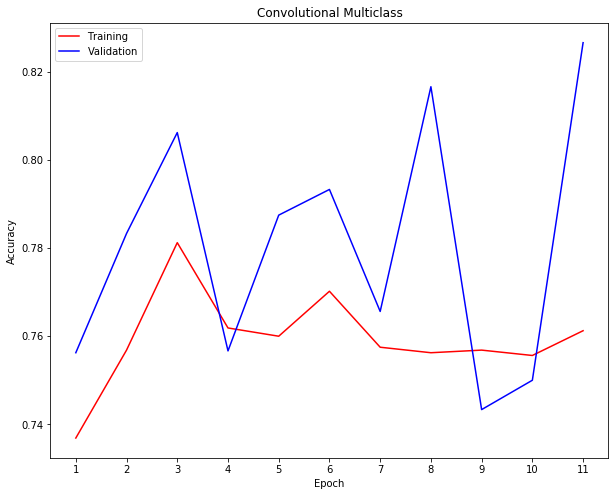

In [35]:
plot_accuracy(conv_hist, 'Convolutional Multiclass')

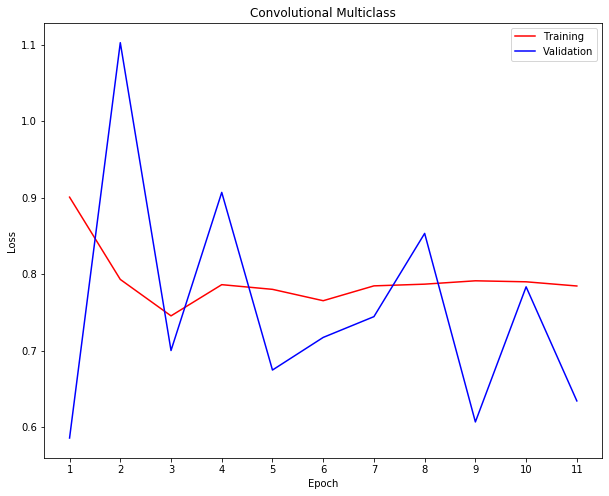

In [36]:
plot_loss(conv_hist, 'Convolutional Multiclass')

In [37]:
def convert_class(y):
    
    lb_list = []
    
    for i in y:
        
        i = list(i)
        
        i_mx = max(i)
        
        i_id = i.index(i_mx)
        
        lb_list.append(i_id)
        
    return np.array(lb_list)

In [38]:
lbls_tr_pred = conv_model.predict(trn_imgs)

In [39]:

lbls_tr_true = convert_class(trn_lbls)
lbls_tr_pred = convert_class(lbls_tr_pred)

In [40]:
np.unique(lbls_tr_pred)

array([2])

In [41]:
print(confusion_matrix(lbls_tr_true, lbls_tr_pred))

[[   0    0  630    0]
 [   0    0  157    0]
 [   0    0 3850    0]
 [   0    0  422    0]]


In [42]:
lbls_vl_pred = conv_model.predict(val_imgs)

In [43]:
lbls_vl_true = convert_class(val_lbls)
lbls_vl_pred = convert_class(lbls_vl_pred)

In [44]:
print(confusion_matrix(lbls_vl_true, lbls_vl_pred))

[[  0   0  62   0]
 [  0   0  19   0]
 [  0   0 433   0]
 [  0   0  42   0]]


# Train Convolution with Augmented Balanced Data

In [46]:
class BalancedDataGenerator(Sequence):
    """ImageDataGenerator + RandomOversampling"""
    def __init__(self, x, y, datagen, batch_size=32):
        self.datagen = datagen
        self.batch_size = batch_size
        self._shape = x.shape        
        datagen.fit(x)
        self.gen, self.steps_per_epoch = balanced_batch_generator(x.reshape(x.shape[0], -1), y, 
                                                                  sampler=RandomOverSampler(), 
                                                                  batch_size=self.batch_size, 
                                                                  keep_sparse=True)

    def __len__(self):
        return self._shape[0] // self.batch_size

    def __getitem__(self, idx):
        x_batch, y_batch = self.gen.__next__()
        x_batch = x_batch.reshape(-1, *self._shape[1:])
        return self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()
    
    
s_datagen = ImageDataGenerator(rotation_range=10, 
                               horizontal_flip=True, 
                               vertical_flip=True)

bgen = BalancedDataGenerator(trn_imgs, trn_lbls, s_datagen, batch_size=32)
steps_per_epoch = bgen.steps_per_epoch

In [47]:
steps_per_epoch

481

In [48]:
conv_model = Sequential()

conv_model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3), activation='relu', padding='same'))
conv_model.add(MaxPool2D((2, 2)))
conv_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
conv_model.add(MaxPool2D((2, 2)))
conv_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
conv_model.add(MaxPool2D((2, 2)))
conv_model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
conv_model.add(MaxPool2D((2, 2)))
conv_model.add(Flatten())
conv_model.add(Dense(512, activation='relu'))
# conv_model.add(Dense(256, activation='relu'))
conv_model.add(Dense(4, activation='softmax'))



conv_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [49]:
np.random.seed(42)

conv_hist = conv_model.fit_generator(bgen, 
                                     steps_per_epoch=481, 
                                     validation_data=val_gen, 
                                     validation_steps=10, 
                                     epochs=11)

Epoch 1/11
481/481 [==============================] - 406s 845ms/step - loss: 1.2353 - accuracy: 0.4161 - val_loss: 1.3124 - val_accuracy: 0.1094
Epoch 2/11
481/481 [==============================] - 385s 800ms/step - loss: 1.0813 - accuracy: 0.4960 - val_loss: 1.3936 - val_accuracy: 0.1433
Epoch 3/11
481/481 [==============================] - 354s 736ms/step - loss: 1.0235 - accuracy: 0.5346 - val_loss: 1.3035 - val_accuracy: 0.1781
Epoch 4/11
481/481 [==============================] - 357s 743ms/step - loss: 0.9842 - accuracy: 0.5567 - val_loss: 1.3376 - val_accuracy: 0.3033
Epoch 5/11
481/481 [==============================] - 348s 723ms/step - loss: 0.9523 - accuracy: 0.5850 - val_loss: 1.1629 - val_accuracy: 0.4313
Epoch 6/11
481/481 [==============================] - 344s 716ms/step - loss: 0.9230 - accuracy: 0.6011 - val_loss: 1.0076 - val_accuracy: 0.4767
Epoch 7/11
481/481 [==============================] - 364s 758ms/step - loss: 0.8965 - accuracy: 0.6213 - val_loss: 1.1805 -

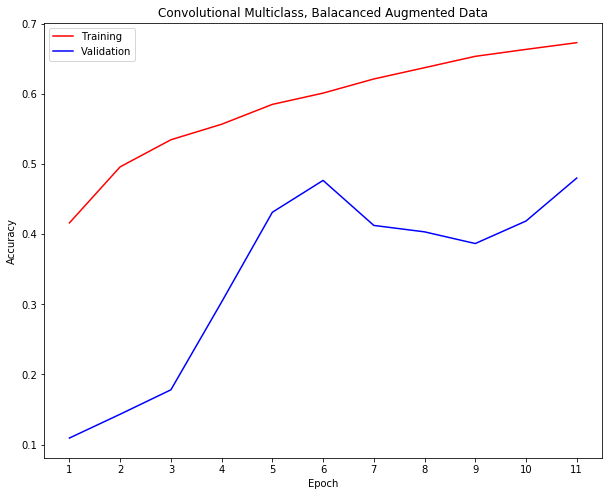

In [50]:
plot_accuracy(conv_hist, 'Convolutional Multiclass, Balacanced Augmented Data')

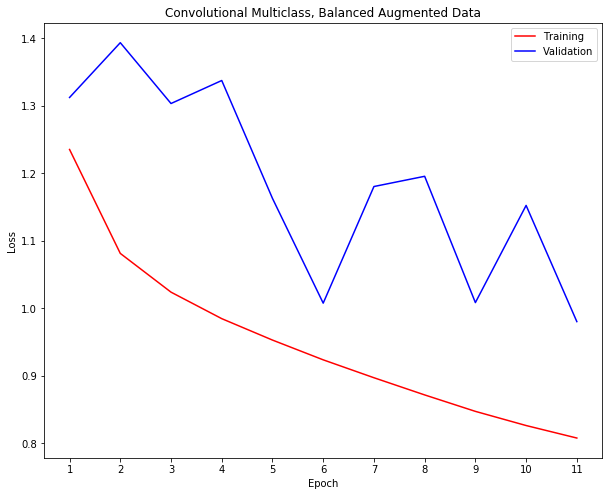

In [51]:
plot_loss(conv_hist, 'Convolutional Multiclass, Balanced Augmented Data')

In [52]:
conv_model.evaluate_generator(trn_gen)

[1.831103801727295, 0.47025102376937866]

In [53]:
conv_model.evaluate_generator(val_gen)

[0.8416612148284912, 0.4766187071800232]

In [54]:
lbls_tr_pred = conv_model.predict(trn_imgs)
lbls_vl_pred = conv_model.predict(val_imgs)

In [55]:
# lbls_vl_true = convert_class(val_lbls)
lbls_vl_pred = convert_class(lbls_vl_pred)
lbls_tr_pred = convert_class(lbls_tr_pred)

In [56]:
print(confusion_matrix(lbls_tr_true, lbls_tr_pred))

[[ 343   85   72  130]
 [   4  141    9    3]
 [ 762  467 1550 1071]
 [  39    8   30  345]]


In [57]:
print(confusion_matrix(lbls_vl_true, lbls_vl_pred))

[[ 36   5   5  16]
 [  0  19   0   0]
 [ 88  51 173 121]
 [  3   1   1  37]]


# Train Convolution with Augmented Data and Dropout

In [58]:
conv_model = Sequential()

conv_model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3), activation='relu', padding='same'))
conv_model.add(MaxPool2D((2, 2)))
conv_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
conv_model.add(MaxPool2D((2, 2)))
conv_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
conv_model.add(MaxPool2D((2, 2)))
conv_model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
conv_model.add(MaxPool2D((2, 2)))
conv_model.add(Flatten())
conv_model.add(Dropout(0.25))
conv_model.add(Dense(512, activation='relu'))
conv_model.add(Dense(4, activation='softmax'))



conv_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [59]:
np.random.seed(42)

conv_hist = conv_model.fit_generator(bgen, 
                                     steps_per_epoch=481, 
                                     validation_data=val_gen, 
                                     validation_steps=10, 
                                     epochs=11)

Epoch 1/11
481/481 [==============================] - 242s 503ms/step - loss: 1.2155 - accuracy: 0.4351 - val_loss: 1.3133 - val_accuracy: 0.1063
Epoch 2/11
481/481 [==============================] - 246s 511ms/step - loss: 1.0734 - accuracy: 0.4999 - val_loss: 1.2888 - val_accuracy: 0.2633
Epoch 3/11
481/481 [==============================] - 231s 480ms/step - loss: 1.0189 - accuracy: 0.5347 - val_loss: 1.0025 - val_accuracy: 0.5500
Epoch 4/11
481/481 [==============================] - 235s 489ms/step - loss: 0.9843 - accuracy: 0.5573 - val_loss: 1.0159 - val_accuracy: 0.6100
Epoch 5/11
481/481 [==============================] - 245s 509ms/step - loss: 0.9542 - accuracy: 0.5853 - val_loss: 0.9260 - val_accuracy: 0.5375
Epoch 6/11
481/481 [==============================] - 248s 517ms/step - loss: 0.9264 - accuracy: 0.6020 - val_loss: 0.7034 - val_accuracy: 0.4667
Epoch 7/11
481/481 [==============================] - 234s 486ms/step - loss: 0.9019 - accuracy: 0.6162 - val_loss: 0.8886 -

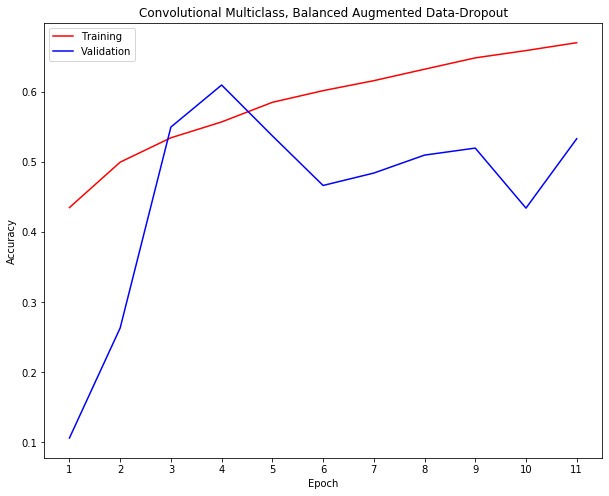

In [60]:
plot_accuracy(conv_hist, 'Convolutional Multiclass, Balanced Augmented Data-Dropout')

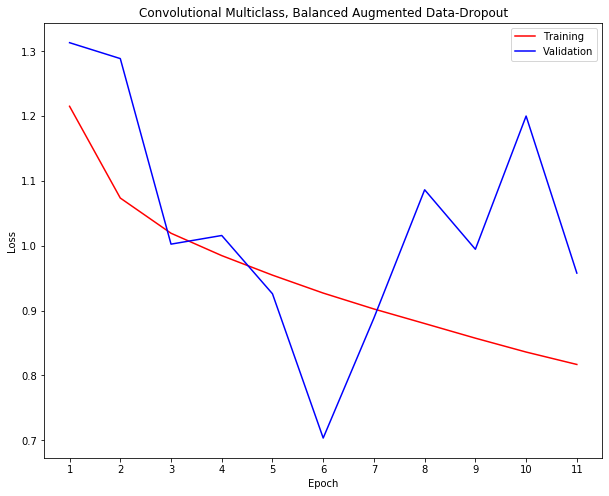

In [61]:
plot_loss(conv_hist, 'Convolutional Multiclass, Balanced Augmented Data-Dropout')

In [62]:
conv_model.evaluate_generator(trn_gen)

[1.6881036758422852, 0.5499110221862793]

In [63]:
conv_model.evaluate_generator(val_gen)

[0.7852892279624939, 0.5521582961082458]

In [64]:
lbls_tr_pred = conv_model.predict(trn_imgs)
lbls_vl_pred = conv_model.predict(val_imgs)


# lbls_vl_true = convert_class(val_lbls)
lbls_vl_pred = convert_class(lbls_vl_pred)
lbls_tr_pred = convert_class(lbls_tr_pred)


In [65]:
print(confusion_matrix(lbls_tr_true, lbls_tr_pred))

[[ 421   67   80   62]
 [  12  138    6    1]
 [1026  336 1953  535]
 [  78    3   71  270]]


In [66]:
print(confusion_matrix(lbls_vl_true, lbls_vl_pred))

[[ 45   4   7   6]
 [  1  18   0   0]
 [115  38 212  68]
 [  5   1   4  32]]


# TTrain Convolution with Augmented Data, Dropout and Batch Normalization

In [67]:
conv_model = Sequential()

conv_model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3), activation='relu', padding='same'))
conv_model.add(BatchNormalization())
conv_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
conv_model.add(MaxPool2D((2, 2)))
# conv_model.add(BatchNormalization())
conv_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
conv_model.add(MaxPool2D((2, 2)))
conv_model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
conv_model.add(MaxPool2D((2, 2)))
conv_model.add(Flatten())
conv_model.add(Dropout(0.25))
conv_model.add(Dense(512, activation='relu'))
conv_model.add(Dense(4, activation='softmax'))



conv_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [68]:
conv_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 150, 150, 64)      18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 75, 75, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 37, 37, 128)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 37, 37, 256)      

In [69]:
np.random.seed(42)

conv_hist = conv_model.fit_generator(bgen, 
                                     steps_per_epoch=481, 
                                     validation_data=val_gen, 
                                     validation_steps=10, 
                                     epochs=11)

Epoch 1/11
481/481 [==============================] - 752s 2s/step - loss: 1.0013 - accuracy: 0.5606 - val_loss: 0.9412 - val_accuracy: 0.5219
Epoch 2/11
481/481 [==============================] - 818s 2s/step - loss: 0.8551 - accuracy: 0.6499 - val_loss: 0.9504 - val_accuracy: 0.4400
Epoch 3/11
481/481 [==============================] - 782s 2s/step - loss: 0.7928 - accuracy: 0.6799 - val_loss: 1.0591 - val_accuracy: 0.4781
Epoch 4/11
481/481 [==============================] - 802s 2s/step - loss: 0.7493 - accuracy: 0.6985 - val_loss: 1.5694 - val_accuracy: 0.4167
Epoch 5/11
481/481 [==============================] - 796s 2s/step - loss: 0.7125 - accuracy: 0.7125 - val_loss: 1.3706 - val_accuracy: 0.4781
Epoch 6/11
481/481 [==============================] - 845s 2s/step - loss: 0.6766 - accuracy: 0.7300 - val_loss: 1.3052 - val_accuracy: 0.4600
Epoch 7/11
481/481 [==============================] - 883s 2s/step - loss: 0.6439 - accuracy: 0.7418 - val_loss: 0.7326 - val_accuracy: 0.5969

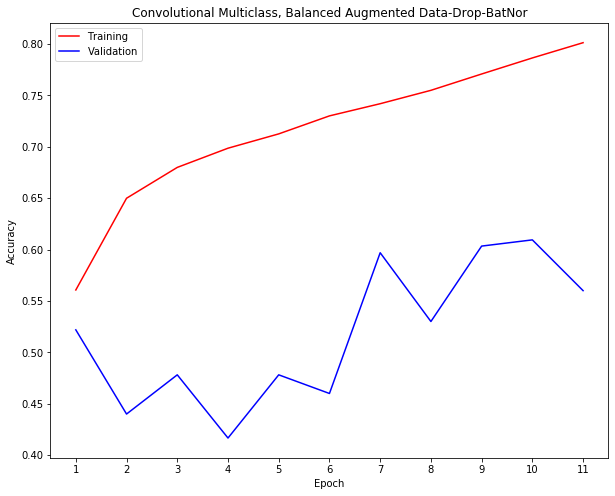

In [70]:
plot_accuracy(conv_hist, 'Convolutional Multiclass, Balanced Augmented Data-Drop-BatNor')

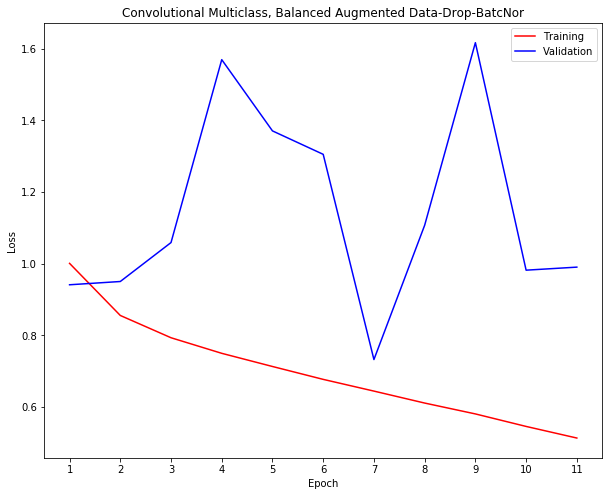

In [77]:
plot_loss(conv_hist, 'Convolutional Multiclass, Balanced Augmented Data-Drop-BatcNor')

In [72]:
conv_model.evaluate_generator(trn_gen)

[1.5357509851455688, 0.5461553931236267]

In [73]:
conv_model.evaluate_generator(val_gen)

[2.0063977241516113, 0.5143885016441345]

In [90]:

lbls_tr_pred = conv_model.predict(trn_imgs)
lbls_vl_pred = conv_model.predict(val_imgs)


# lbls_vl_true = convert_class(val_lbls)
lbls_vl_pred = convert_class(lbls_vl_pred)
lbls_tr_pred = convert_class(lbls_tr_pred)


print(confusion_matrix(lbls_tr_true, lbls_tr_pred))

print('')
print(confusion_matrix(lbls_vl_true, lbls_vl_pred))

[[ 540   24   37   29]
 [   4  138   15    0]
 [ 674   75 2318  783]
 [  37    3   29  353]]

[[ 46   1   8   7]
 [  1  18   0   0]
 [ 74  15 249  95]
 [  5   0   3  34]]


# Train with Batch Normalization

In [78]:
conv_model = Sequential()

conv_model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3), activation='relu', padding='same'))
conv_model.add(BatchNormalization())
conv_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
conv_model.add(MaxPool2D((2, 2)))
# conv_model.add(SpatialDropout2D(0.1))
conv_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
conv_model.add(MaxPool2D((2, 2)))
# conv_model.add(SpatialDropout2D(0.1))
conv_model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
conv_model.add(MaxPool2D((2, 2)))
conv_model.add(Flatten())
# conv_model.add(Dropout(0.25))
conv_model.add(Dense(512, activation='relu'))
conv_model.add(Dense(4, activation='softmax'))



conv_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [79]:
conv_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
batch_normalization_3 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 150, 150, 64)      18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 75, 75, 128)       73856     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 37, 37, 128)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 37, 37, 256)      

In [ ]:
np.random.seed(42)

conv_hist = conv_model.fit_generator(bgen, 
                                     steps_per_epoch=481, 
                                     validation_data=val_gen, 
                                     validation_steps=10, 
                                     epochs=11)

Epoch 1/11
481/481 [==============================] - 708s 1s/step - loss: 1.0098 - accuracy: 0.5569 - val_loss: 1.1325 - val_accuracy: 0.4781
Epoch 2/11
349/481 [====================>.........] - ETA: 3:21 - loss: 0.8634 - accuracy: 0.6485

In [ ]:
plot_accuracy(conv_hist, 'Convolutional Multiclass, Balanced Augmented Data-BatNor')

In [ ]:
plot_loss(conv_hist, 'Convolutional Multiclass, Balanced Augmented Data-Drop-BatcNor')

In [ ]:
conv_model.evaluate_generator(trn_gen)

In [ ]:
conv_model.evaluate_generator(val_gen)

In [ ]:
lbls_tr_pred = conv_model.predict(trn_imgs)
lbls_vl_pred = conv_model.predict(val_imgs)


# lbls_vl_true = convert_class(val_lbls)
lbls_vl_pred = convert_class(lbls_vl_pred)
lbls_tr_pred = convert_class(lbls_tr_pred)


print(confusion_matrix(lbls_tr_true, lbls_tr_pred))

print('')
print(confusion_matrix(lbls_vl_true, lbls_vl_pred))

# Train Resnet model

In [116]:
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

/Users/carlostavarez/opt/anaconda3/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [117]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 75, 75, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [118]:
# # resnet.layers = True

# bolck_bol = False

# for idx in range(len(resnet.layers)):
    
#     if resnet.layers[idx].name in ['conv1', 'activation_50']:
#         resnet.layers[idx].trainable = True
# #         bolck_bol = True
        
# #     if bolck_bol:
# #         resnet.layers[idx].trainable = True
        
#     else:
#         resnet.layers[idx].trainable = False

In [119]:
model = Sequential()

model.add(resnet)
# model.add(Conv2D(4096, (3, 3), activation='relu'))
# model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
# model.add(Dense(200, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [120]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten_16 (Flatten)         (None, 51200)             0         
_________________________________________________________________
dense_29 (Dense)             (None, 512)               26214912  
_________________________________________________________________
dense_30 (Dense)             (None, 4)                 2052      
Total params: 49,804,676
Trainable params: 49,751,556
Non-trainable params: 53,120
_________________________________________________________________


In [121]:
history = model.fit_generator(bgen, 
                              steps_per_epoch=481, 
                              validation_data=val_gen, 
                              validation_steps=5, 
                              epochs=10)

KeyboardInterrupt: 

In [118]:
# model.evaluate_generator(trn_gen)

In [ ]:
model.evaluate_generator(val_gen)

In [ ]:
lbls_tr_pred_resnet = model.predict(trn_imgs)
# lbls_tr_true = convert_class(trn_lbls)
lbls_tr_pred_resnet = convert_class(lbls_tr_pred_resnet)

In [ ]:
print(confusion_matrix(lbls_tr_true, lbls_tr_pred_resnet))

In [ ]:
plot_accuracy(history, 'Resnet Training')

In [ ]:
plot_loss(history, 'Resnet Training')

In [118]:
conv_model = Sequential()

conv_model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3), activation='relu', padding='same'))
conv_model.add(MaxPool2D((2, 2)))
conv_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
conv_model.add(MaxPool2D((2, 2)))
conv_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
conv_model.add(MaxPool2D((2, 2)))
conv_model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
conv_model.add(MaxPool2D((2, 2)))
conv_model.add(Flatten())
conv_model.add(Dense(512, activation='relu'))
conv_model.add(Dense(5, activation='sigmoid'))



conv_model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['acc'])

In [119]:
conv_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 18, 18, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 18, 18, 256)      

In [120]:
history_conv = conv_model.fit_generator(trn_gen, 
                              steps_per_epoch=200, 
                              validation_data=val_gen, 
                              validation_steps=50, 
                              epochs=10)

Epoch 1/10
200/200 [==============================] - 104s 518ms/step - loss: 0.4235 - acc: 0.8107 - val_loss: 0.3446 - val_acc: 0.8050
Epoch 2/10
200/200 [==============================] - 105s 523ms/step - loss: 0.3599 - acc: 0.8303 - val_loss: 0.3661 - val_acc: 0.8299
Epoch 3/10
200/200 [==============================] - 105s 524ms/step - loss: 0.3523 - acc: 0.8411 - val_loss: 0.3164 - val_acc: 0.8408
Epoch 4/10
200/200 [==============================] - 112s 559ms/step - loss: 0.3388 - acc: 0.8525 - val_loss: 0.3366 - val_acc: 0.8675
Epoch 5/10
200/200 [==============================] - 108s 538ms/step - loss: 0.3301 - acc: 0.8557 - val_loss: 0.4334 - val_acc: 0.8283
Epoch 6/10
200/200 [==============================] - 115s 576ms/step - loss: 0.3239 - acc: 0.8611 - val_loss: 0.3385 - val_acc: 0.8486
Epoch 7/10
200/200 [==============================] - 112s 562ms/step - loss: 0.3215 - acc: 0.8626 - val_loss: 0.4799 - val_acc: 0.8595
Epoch 8/10
200/200 [============================

In [125]:
conv_model.evaluate_generator(trn_gen)

[0.2549809217453003, 0.8648634552955627]

In [126]:
conv_model.evaluate_generator(val_gen)

[0.23706145584583282, 0.8688014149665833]

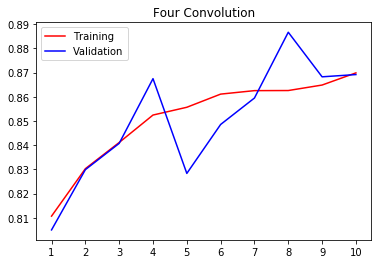

In [127]:
plot_accuracy(history_conv, 'Four Convolution')

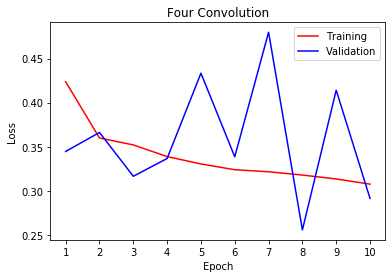

In [128]:
plot_loss(history_conv, 'Four Convolution')

In [132]:
conv_model2 = Sequential()

conv_model2.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3), activation='relu', padding='same'))
conv_model2.add(MaxPool2D((2, 2)))
conv_model2.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
conv_model2.add(MaxPool2D((2, 2)))
conv_model2.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
conv_model2.add(MaxPool2D((2, 2)))
# conv_model2.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
# conv_model2.add(MaxPool2D((2, 2)))
# conv_model2.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
# conv_model2.add(MaxPool2D((2, 2)))
conv_model2.add(Flatten())
conv_model2.add(Dense(512, activation='relu'))
conv_model2.add(Dense(5, activation='sigmoid'))



conv_model2.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['acc'])

In [133]:
conv_model2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 18, 18, 128)       0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 41472)            

In [134]:
history_conv2 = conv_model2.fit_generator(trn_gen, 
                              steps_per_epoch=200, 
                              validation_data=val_gen, 
                              validation_steps=50, 
                              epochs=10)

Epoch 1/10
200/200 [==============================] - 106s 529ms/step - loss: 0.3934 - acc: 0.8092 - val_loss: 0.3098 - val_acc: 0.8247
Epoch 2/10
200/200 [==============================] - 108s 540ms/step - loss: 0.3504 - acc: 0.8394 - val_loss: 0.3141 - val_acc: 0.8613
Epoch 3/10
200/200 [==============================] - 103s 514ms/step - loss: 0.3401 - acc: 0.8544 - val_loss: 0.3328 - val_acc: 0.8538
Epoch 4/10
200/200 [==============================] - 100s 502ms/step - loss: 0.3277 - acc: 0.8592 - val_loss: 0.2269 - val_acc: 0.8772
Epoch 5/10
200/200 [==============================] - 110s 548ms/step - loss: 0.3248 - acc: 0.8620 - val_loss: 0.3432 - val_acc: 0.8674
Epoch 6/10
200/200 [==============================] - 115s 573ms/step - loss: 0.3135 - acc: 0.8648 - val_loss: 0.2612 - val_acc: 0.8745
Epoch 7/10
200/200 [==============================] - 105s 526ms/step - loss: 0.3130 - acc: 0.8651 - val_loss: 0.2455 - val_acc: 0.8718
Epoch 8/10
200/200 [============================

In [135]:
conv_model2.evaluate_generator(trn_gen)

[0.24978137016296387, 0.8821313977241516]

In [136]:
conv_model2.evaluate_generator(val_gen)

[0.4734634757041931, 0.8911253213882446]

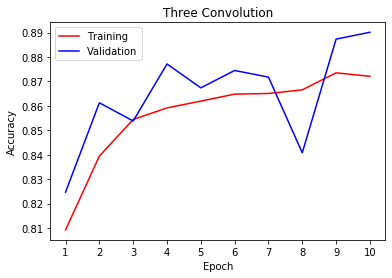

In [137]:
plot_accuracy(history_conv2, 'Three Convolution')

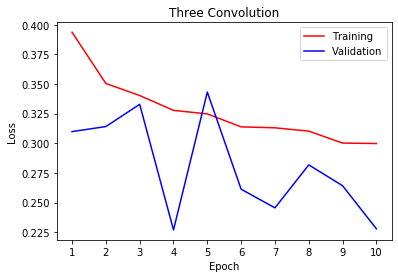

In [138]:
plot_loss(history_conv2, 'Three Convolution')

In [88]:
class BalancedDataGenerator(Sequence):
    """ImageDataGenerator + RandomOversampling"""
    def __init__(self, x, y, datagen, batch_size=32):
        self.datagen = datagen
        self.batch_size = batch_size
        self._shape = x.shape        
        datagen.fit(x)
        self.gen, self.steps_per_epoch = balanced_batch_generator(x.reshape(x.shape[0], -1), y, sampler=RandomOverSampler(), batch_size=self.batch_size, keep_sparse=True)

    def __len__(self):
        return self._shape[0] // self.batch_size

    def __getitem__(self, idx):
        x_batch, y_batch = self.gen.__next__()
        x_batch = x_batch.reshape(-1, *self._shape[1:])
        return self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()
    
    
s_datagen = ImageDataGenerator(rescale=1.0/255, 
                               rotation_range=40, 
                               width_shift_range=0.2, 
                               height_shift_range=0.2, 
                               shear_range=0.2, 
                               zoom_range=0.2,
                               horizontal_flip=True)

bgen = BalancedDataGenerator(x_trn, y_trn, s_datagen, batch_size=32)
steps_per_epoch = bgen.steps_per_epoch

In [36]:
# train_gen = datagen.flow(x_trn, y_trn, batch_size=20)
# valid_gen = datagen.flow(x_val, y_val, batch_size=20)

s_datagen = ImageDataGenerator(rescale=1.0/255, 
                               rotation_range=40, 
                               width_shift_range=0.2, 
                               height_shift_range=0.2, 
                               shear_range=0.2, 
                               zoom_range=0.2,
                               horizontal_flip=True)

bgen = BalancedDataGenerator(x_trn, y_trn, s_datagen, batch_size=32)
steps_per_epoch = bgen.steps_per_epoch

In [37]:
# bgen_vl = datagen.flow(x_val, y_val, batch_size=32)
# steps_val = bgen_vl.steps_per_epoch

In [38]:
valid_gen = datagen.flow(x_val, y_val, batch_size=32)

In [39]:
steps_per_epoch, steps_val

(579, 64)

In [48]:
history = model.fit_generator(bgen, 
                              steps_per_epoch=steps_per_epoch, 
                              validation_data=valid_gen, 
                              validation_steps=len(x_val)//32, 
                              epochs=10)

Epoch 1/10
579/579 [==============================] - 3569s 6s/step - loss: 0.7329 - acc: 0.7209 - val_loss: 1.0879 - val_acc: 0.6974
Epoch 2/10
579/579 [==============================] - 3551s 6s/step - loss: 0.5215 - acc: 0.8031 - val_loss: 2.2688 - val_acc: 0.1298
Epoch 3/10
579/579 [==============================] - 3627s 6s/step - loss: 0.4656 - acc: 0.8258 - val_loss: 2.5201 - val_acc: 0.1239
Epoch 4/10
579/579 [==============================] - 3881s 7s/step - loss: 0.4254 - acc: 0.8437 - val_loss: 2.1979 - val_acc: 0.0369
Epoch 5/10
579/579 [==============================] - 3731s 6s/step - loss: 0.4047 - acc: 0.8522 - val_loss: 2.0635 - val_acc: 0.0339
Epoch 6/10
579/579 [==============================] - 3626s 6s/step - loss: 0.3921 - acc: 0.8556 - val_loss: 1.9155 - val_acc: 0.0310
Epoch 7/10
579/579 [==============================] - 3642s 6s/step - loss: 0.3725 - acc: 0.8631 - val_loss: 2.1238 - val_acc: 0.0428
Epoch 8/10
579/579 [==============================] - 3636s 6s

In [49]:
model.evaluate_generator(bgen)

[2.2005739212036133, 0.25015702843666077]

In [50]:
model.evaluate_generator(valid_gen)

[3.1303462982177734, 0.035211268812417984]

In [32]:
y_trn

array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [33]:
y_trn_pred = model.predict(x_trn)

In [34]:
y_val_pred = model.predict(x_val)

In [35]:
y_trn_pred

array([[4.4343080e-03, 1.4488957e-03, 9.8969406e-01, 4.4227676e-03],
       [1.7619923e-06, 1.0551557e-07, 9.9999809e-01, 1.4338494e-08],
       [2.9367459e-04, 5.9036534e-05, 9.9931002e-01, 3.3724587e-04],
       ...,
       [5.7238364e-04, 1.6210042e-04, 9.9840242e-01, 8.6316268e-04],
       [8.1247366e-05, 1.8141752e-04, 9.9636590e-01, 3.3714673e-03],
       [1.9814749e-04, 2.8437789e-05, 9.9947459e-01, 2.9880885e-04]],
      dtype=float32)

In [43]:
p = list(y_trn_pred[0])

In [47]:
p_mx = max(p)

In [48]:
p.index(p_mx)

2

In [49]:
def convert_class(y):
    
    lb_list = []
    
    for i in y:
        
        i = list(i)
        
        i_mx = max(i)
        
        i_id = i.index(i_mx)
        
        lb_list.append(i_id)
        
    return np.array(lb_list)

In [51]:
y_tr_lb = convert_class(y_trn)

In [52]:
y_tr_lb_pred = convert_class(y_trn_pred)

In [53]:
y_vl_lb = convert_class(y_val)
y_vl_lb_pred = convert_class(y_val_pred)

In [57]:
y_trn

array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [65]:
# training

confusion_matrix(y_tr_lb, y_tr_lb_pred)

array([[ 132,    4,  671,    0],
       [   2,   16,  204,    0],
       [   6,    0, 4629,    0],
       [   0,    0,  721,    0]])

In [67]:
print(classification_report(y_tr_lb, y_tr_lb_pred))

              precision    recall  f1-score   support

           0       0.94      0.16      0.28       807
           1       0.80      0.07      0.13       222
           2       0.74      1.00      0.85      4635
           3       0.00      0.00      0.00       721

    accuracy                           0.75      6385
   macro avg       0.62      0.31      0.32      6385
weighted avg       0.69      0.75      0.66      6385



In [71]:
accuracy_score(y_tr_lb, y_tr_lb_pred)

0.748159749412686

In [68]:
# validation

confusion_matrix(y_vl_lb, y_vl_lb_pred)

array([[ 16,   1,  73,   0],
       [  0,   4,  21,   0],
       [  0,   0, 515,   0],
       [  0,   0,  80,   0]])

In [69]:
print(classification_report(y_vl_lb, y_vl_lb_pred))

              precision    recall  f1-score   support

           0       1.00      0.18      0.30        90
           1       0.80      0.16      0.27        25
           2       0.75      1.00      0.86       515
           3       0.00      0.00      0.00        80

    accuracy                           0.75       710
   macro avg       0.64      0.33      0.36       710
weighted avg       0.70      0.75      0.67       710



In [72]:
accuracy_score(y_vl_lb, y_vl_lb_pred)

0.7535211267605634

## Second model

In [73]:
model = Sequential()

model.add(resnet)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])

In [74]:
history = model.fit_generator(train_gen, 
                              steps_per_epoch=len(x_trn)//20, 
                              validation_data=valid_gen, 
                              validation_steps=len(x_val)//20, 
                              epochs=10)

Epoch 1/10
319/319 [==============================] - 546s 2s/step - loss: 0.5471 - acc: 0.7884 - val_loss: 1.1094 - val_acc: 0.7214
Epoch 2/10
319/319 [==============================] - 466s 1s/step - loss: 0.2994 - acc: 0.8742 - val_loss: 0.8498 - val_acc: 0.7304
Epoch 3/10
179/319 [===============>..............] - ETA: 2:59 - loss: 0.2055 - acc: 0.9128

KeyboardInterrupt: 